# Neural Networks for Classification, and Clustering

In this notebook we are going to explore the use of Neural Networks for image classification. We are going to use a dataset of small images of clothes and accessories, the Fashion MNIST. You can find more information regarding the dataset here: https://pravarmahajan.github.io/fashion/

Each instance in the dataset consist of an image, in a format similar to the digit images you have seen in the previous homework, and a label. The labels correspond to the type of clothing, as follows:

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

Let's first load the required packages.

In [1]:
#load the required packages

%matplotlib inline  

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

#for display purposes
import pandas

The following block is a Timer class used for comparisation purposes later on

In [2]:
#for comparisation purposes
import time as TIME

class Timer:
        
    def __init__(self):
        self.first = 0
        self.second = self.first
    
    def start(self):
        self.first = TIME.time()
        
    def stop(self):
        self.second = TIME.time()
        
    def passed_time(self):
        time =  self.second - self.first
        minutes = int((time)/60)
        seconds = round((time)%60, 3)
        return {'min' : minutes, 'sec': seconds}
    
    def __str__(self):
        time = self.passed_time()
        return str(time['min']) + "min " + str(time['sec']) + "sec."
    
timer = Timer()

The following is a function to load the data, that we are going to use later in the notebook.

In [3]:
# helper function to load Fashion MNIST dataset from disk
def load_fashion_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte.gz' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte.gz' % kind)
    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,offset=8)
    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,offset=16).reshape(len(labels), 784)
    return images, labels

## TO DO 0
Place your ID ("numero di matricola") that will be used as seed for random generator. Change the ID number in case you observe unexpected behaviours and want to test if this is due to randomization (e.g., train/test split). If you change the ID number explain why you have change it.

In [4]:
ID = 2026826 # COMPLETE
np.random.seed(ID)

Now we load the dataset using the function above.

In [5]:
#load the fashion MNIST dataset and normalize the features so that each value is in [0,1]
X, y = load_fashion_mnist("data")
# rescale the data
X = X / 255.0

Now we split the data into training and test. Make sure that each label is present at least 10 times
in the training set.

In [6]:
#random permute the data and split into training and test taking the first 500
#data samples as training and the rest as test
permutation = np.random.permutation(X.shape[0])

X = X[permutation]
y = y[permutation]

m_training = 500

X_train, X_test = X[:m_training], X[m_training:]
y_train, y_test = y[:m_training], y[m_training:]

labels, freqs = np.unique(y_train, return_counts=True)
print("Labels in training dataset: ", labels)
print("Frequencies in training dataset: ", freqs)

Labels in training dataset:  [0 1 2 3 4 5 6 7 8 9]
Frequencies in training dataset:  [49 47 57 44 49 52 51 59 49 43]


#### STUDENT NOTES
In the following block checks if there are at least 10 elements for each label. If not, it will be added permutations until the condition is satisfied.

In [7]:
labels, labels_qty = np.unique(y_train, return_counts = True)

while(not(np.all(labels_qty >= 10))):
    permutation = np.random.permutation(X.shape[0])

    X = X[permutation]
    y = y[permutation]

    m_training = 500

    X_train, X_test = X[:m_training], X[m_training:]
    y_train, y_test = y[:m_training], y[m_training:]
    
    labels, labels_qty = np.unique(y_train, return_counts = True)
 
np.unique(y_train, return_counts = True)  

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([49, 47, 57, 44, 49, 52, 51, 59, 49, 43], dtype=int64))

The following function plots an image and the corresponding label, to be used to inspect the data when needed.

In [8]:
#function for plotting a image and printing the corresponding label
def plot_input(X_matrix, labels, index):
    print("INPUT:")
    plt.imshow(
        X_matrix[index].reshape(28,28),
        cmap          = plt.cm.gray_r,
        interpolation = "nearest"
    )
    plt.show()
    print("LABEL: %i"%labels[index])
    return

Now let's test the function above and check few images.

INPUT:


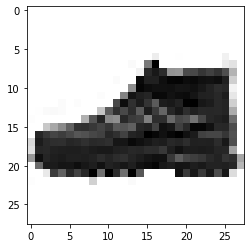

LABEL: 7
INPUT:


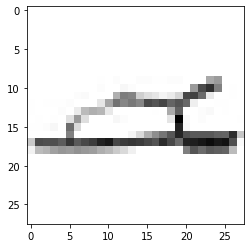

LABEL: 5
INPUT:


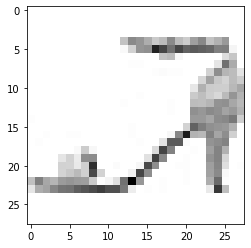

LABEL: 5


In [9]:
#let's try the plotting function
plot_input(X_train,y_train,10)
plot_input(X_test,y_test,50)
plot_input(X_test,y_test,300)

## TO DO 1

Now use a (feed-forward) Neural Network for prediction. Use the multi-layer perceptron (MLP) classifier MLPClassifier(...) in scikit-learn, with the following parameters: max_iter=300, alpha=1e-4, solver='sgd', tol=1e-4, learning_rate_init=.1, random_state=ID (this last parameter ensures the run is the same even if you run it more than once). The alpha parameter is the regularization parameter for L2 regularization that is used by the MLP in sklearn.

Then, using the default activation function, pick four or five architectures to consider, with different numbers of hidden layers and different sizes. It is not necessary to create huge neural networks, you can limit to 3 layers and, for each layer, its maximum size can be of 100. You can evaluate the architectures you chose using the GridSearchCV with a 5-fold cross-validation, and use the results to pick the best architecture. The code below provides some architectures you can use, but you can choose other ones if you prefer.


In [10]:
#MLPclassifier requires in input the parameter hidden_layer_sizes, that is a tuple specifying the number of 
#neurons in the hidden layers; for example: (10,) means that there is only 1 hidden layer with 10 neurons; 
#(10,50) means that there are 2 hidden layers, the first with 10 neurons, the second with 50 neurons

#these are examples of possible architectures you can test, but feel free to use different architectures! 
hl_parameters = {'hidden_layer_sizes': [(10,), (50,), (100,), 
                                        (10,10,), (50,50,), (100,100,),
                                        (10,10,10,), (50,50,50,), (100,100,100,)]}

mlp_cv = MLPClassifier(max_iter=300,
                       alpha=1e-4,
                       solver='sgd',
                       tol=1e-4,
                       learning_rate_init=.1, 
                       random_state=ID) #ADD YOUR CODE

mlp_cv = GridSearchCV(mlp_cv, hl_parameters).fit(X_train, y_train)

print ('RESULTS FOR NN\n')

print("Best parameters set found:")
# ADD CODE
print(mlp_cv.best_params_)

print("Score with best parameters:")
# ADD CODE
print(mlp_cv.best_score_)

print("\nAll scores on the grid:")
# ADD CODE
scores = mlp_cv.cv_results_['mean_test_score']
params = hl_parameters['hidden_layer_sizes']
results = [{'params' : value, 'score' : scores[index]} for index, value in enumerate(params)]
display(pandas.DataFrame(results).T)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


RESULTS FOR NN

Best parameters set found:
{'hidden_layer_sizes': (100,)}
Score with best parameters:
0.766

All scores on the grid:


,0,1,2,3,4,5,6,7,8
params,"(10,)","(50,)","(100,)","(10, 10)","(50, 50)","(100, 100)","(10, 10, 10)","(50, 50, 50)","(100, 100, 100)"
score,0.718,0.76,0.766,0.58,0.744,0.754,0.356,0.602,0.656


## TO DO 2

What do you observe for different architectures and their scores? How do the number of layers and their sizes affect the performances?

#### ANSWER

*For the cross valdation: for each depth set, it has been added an 100 nodes hidden layer (e.g. depth=2 set, two 100 nodes hidden layers added) and it has been added a set of hidden layers of depth=3.<br>
This adding has been done to add more results and have a better representation of the NN behaviour with the increasing depth and size of the hidden layers.*

Among the depth set, we observe that the scores improves with the increasing of the number of nodes/neurons, but this scores tends to converge. We also observe that increasing the number of layers make the performances worse.
To conclude, the best result obtained is with the NN with 1 hidden layer and 100 nodes with a score of 76.6%, but at the same time this score si quite similar to the the NN with 1 hidden layer and 50 nodes (there is a difference of only 6%); therefore in a real world application the best archituecture it might be the NN with 50 nodes because it requires less computation time.

## TO DO 3

Now get training and test error (according to the initial split) for a NN with best parameters chosen from the cross-validation above (and learning the NN weights from the entire training set). Use verbose=True
in input so to see how loss changes in iterations. (Note that the loss used by the MLPclassifier may be different from the 0-1 loss, also called *accuracy*.)

In [11]:
#get training and test error for the best NN model from CV

mlp = mlp_cv.best_estimator_.fit(X_train, y_train) #ADD YOUR CODE

training_error = 1 - mlp.score(X_train, y_train) #ADD YOUR CODE

test_error = 1 - mlp.score(X_test, y_test) #ADD YOUR CODE

print ('\nRESULTS FOR BEST NN\n')

print ("Best NN training error: %f" % training_error)
print ("Best NN test error: %f" % test_error)


RESULTS FOR BEST NN

Best NN training error: 0.000000
Best NN test error: 0.211059


## More data 
Now let's do the same but using 10000 (or less if it takes too long on your machine) data points for training. Use the same NN architectures as before, but you can try more if you want!

In [12]:
X = X[permutation]
y = y[permutation]

m_training = 10000

X_train, X_test = X[:m_training], X[m_training:]
y_train, y_test = y[:m_training], y[m_training:]

print("Labels and frequencies in training dataset: ")
np.unique(y_train, return_counts=True)

Labels and frequencies in training dataset: 


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([ 990, 1002, 1059,  984, 1021, 1005,  997, 1012,  968,  962],
       dtype=int64))

## TO DO 4

Now train the NNs with the added data points. Feel free to try more different architectures than before if you want, or less if it takes too much time. You can use 'verbose=True' so have an idea of how long it takes to run 1 iteration (eventually reduce also the number of iterations to 50).

In [13]:
#for NN we try the same architectures as before
hl_parameters = {'hidden_layer_sizes': [(50,), (100,),
                                        (50,50,), (100,100),
                                        (50,50,50,)]}

mlp_large_cv = MLPClassifier(max_iter=300,
                             alpha=1e-4,
                             solver='sgd',
                             tol=1e-4,
                             learning_rate_init=.1,
                             #verbose=True,
                             random_state=ID) #ADD YOUR CODE

timer.start()
mlp_large_cv = GridSearchCV(mlp_large_cv, hl_parameters).fit(X_train, y_train)
timer.stop()
print("\nCV total time: ", timer)

print ('\nRESULTS FOR NN\n')

print("Best parameters set found:")
# ADD CODE
print(mlp_large_cv.best_params_)

print("Score with best parameters:")
# ADD CODE
print(mlp_large_cv.best_score_)

print("\nAll scores on the grid:")
# ADD CODE
scores = mlp_large_cv.cv_results_['mean_test_score']
params = hl_parameters['hidden_layer_sizes']
results = [{'params' : value, 'score' : scores[index]} for index, value in enumerate(params)]
display(pandas.DataFrame(results).T)


CV total time:  9min 47.964sec.

RESULTS FOR NN

Best parameters set found:
{'hidden_layer_sizes': (100,)}
Score with best parameters:
0.8576

All scores on the grid:


,0,1,2,3,4
params,"(50,)","(100,)","(50, 50)","(100, 100)","(50, 50, 50)"
score,0.8383,0.8576,0.8476,0.8532,0.8453


## TO DO 5
Describe your architecture choices and the results you observe with respect to the architectures you used.

#### ANSWER

The cross validation is done with the following considerations:
1. CV is done without considering NNs with the hidden layers of 10 nodes because they produce poor results and to save computation time;
2. the NN with depth 3 and 100 nodes for each hidden layer is not used for the CV to save computation time and because, due to the considerations previously done, we already know that it will not improve its score;
3. it's kept the [50, 50, 50,] NN for a comparisation reason that will be seen later on.

*Unfortunately, in my PC, doing the cross validations with the same NN of before takes more than 10 minutes, instead with this kind of architecture takes 7 minutes.*

As before with 500 samples, the scores are getting worse with the depth of the architectures, but they are improving with increasing number of nodes on the same depth and the improving looks like it tends to converge. And as before we have the best result withe the NN with depth=1 and 100 nodes in the hidden layer.<br>
However, this time there is an unexpected small improving in the [50, 50,] NN in respect with the [50,] NN, but the improving is still not enough to be eligible as the best score. Anyway with the [50, 50, 50,] NN the score starts to decrese as seen previously.

This unexpected behaviour might change the considerations done before regarding a real world applications, but if we consider the computation time and the fact that the score improving is not that much in the [100,] and [50,50,] NNs than the [50,] NN, then the best choice is still the [50,] NN.

## TO DO 6

Get the train and test error for the best NN you obtained with 10000 points. This time you can run for 100 iterations if you cannot run for 300 iterations. 


In [14]:
#get training and test error for the best NN model from CV

timer.start()
best_mlp_large = mlp_large_cv.best_estimator_.fit(X_train,y_train)#ADD YOUR CODE
timer.stop()
print('Training time: ',timer)

training_error = 1 - best_mlp_large.score(X_train, y_train) #ADD YOUR CODE

timer.start()
test_error = 1 - best_mlp_large.score(X_test, y_test) #ADD YOUR CODE
timer.stop()
print('X_test data prediction time: ', timer)

print ('\nRESULTS FOR BEST NN\n')

print ("Best NN training error: %f" % training_error)
print ("Best NN test error: %f" % test_error)

Training time:  0min 33.775sec.
X_test data prediction time:  0min 0.434sec.

RESULTS FOR BEST NN

Best NN training error: 0.003500
Best NN test error: 0.141900


## TO DO 7

Compare the train and test error you got with a large number of samples with the best one you obtained with only 500 data points. Are the architectures the same or do they differ? What about the errors you get?

#### ANSWER

| #Samples | Architecture | Training error | Test Error |
|---| --- | --- | --- |
| 500 | [100,] | 0.00% | 21.11% |
| 10000 | [100,] | 0.35% | 14.19% |

The CVs have found out that best architecture for both tests is the same, that is the a NN with 1 hidden layer and 100 nodes in it.

*From now on the NN trained with 10000 samples is called 10000-NN and the other one is called 500-NN*

The 10000-NN has a worse training error than the 500-N, which is zero; this is due to the fact that is harder to correctly classify the a big data set than a smaller one.
But, the 10000-NN has a better result with the test error (around 6% of difference) than the 500-NN this is because, as we can expect, the model is trained with more data and with more data there is an higher possibility of better representation of the real world, therefore it can be learned a more realistic model.

## TO DO 8

Plot an image that was missclassified by NN with m=500 training data points and it is now instead correctly classified by NN with m=10000 training data points.

Classification from 500-NN [MISSCLASSIFIED]
INPUT:


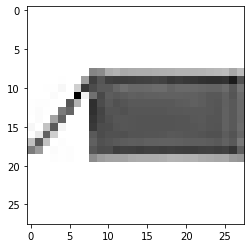

LABEL: 7

Classification from 1000-NN [CORRECTLY CLASSIFIED]
INPUT:


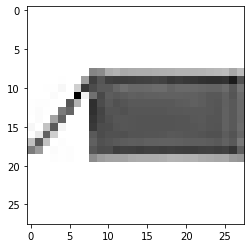

LABEL: 8


In [15]:
#ADD YOUR CODE

mlp_labels = mlp.predict(X_test)
mlp_large_labels = best_mlp_large.predict(X_test)
for index, value in enumerate(y_test):
    if (value != mlp_labels[index]) and (value == mlp_large_labels[index]):
        print("Classification from 500-NN [MISSCLASSIFIED]")
        plot_input(X_test, mlp_labels, index)
        print("\nClassification from 1000-NN [CORRECTLY CLASSIFIED]")
        plot_input(X_test, mlp_large_labels, index)
        break

Let's plot some of the weigths of the multi-layer perceptron classifier, for the best NN we get with 500 data points and with 10000 data points. The code below plots the weights in a matrix form, where a figure represents all the weights of the edges entering in a hidden node. Notice that the code assumes that the NNs are called "mlp" and "best_mlp_large": you may need to replace such variables with your variable names. 



Weights with 500 data points:


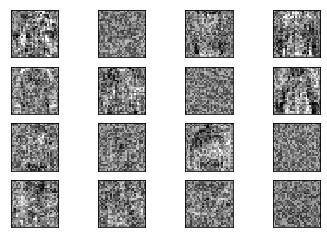

Weights with 10000 data points:


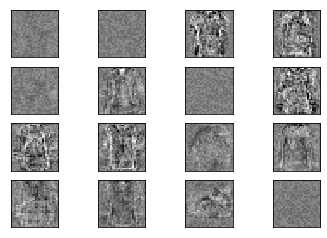

In [16]:
print("Weights with 500 data points:")

fig, axes = plt.subplots(4, 4)
vmin, vmax = mlp.coefs_[0].min(), mlp.coefs_[0].max()
for coef, ax in zip(mlp.coefs_[0].T, axes.ravel()):
    ax.matshow(coef.reshape(28, 28), cmap=plt.cm.gray, vmin=.5 * vmin, vmax=.5 * vmax)
    ax.set_xticks(())
    ax.set_yticks(())

plt.show()

print("Weights with 10000 data points:")

fig, axes = plt.subplots(4, 4)
vmin, vmax = best_mlp_large.coefs_[0].min(), best_mlp_large.coefs_[0].max()
for coef, ax in zip(best_mlp_large.coefs_[0].T, axes.ravel()):
    ax.matshow(coef.reshape(28, 28), cmap=plt.cm.gray, vmin=.5 * vmin, vmax=.5 * vmax)
    ax.set_xticks(())
    ax.set_yticks(())
plt.show()

## TO DO 9

Describe what do you observe by looking at the weights.

#### ANSWER

*I assume that the black is the lowest value and the white is the highest value in plotted matrices*

With the 500-NN we can observe very noisy images, therefore the matrices points are manly black (or very dark) and white (or very light), there are few points that tend do be grey. This means that the weight in the NN are mainly or close to the lowest value (dark color) or close to the highest value (light color) of the 500-NN coefficients.

Instead in the 10000-NN the plots are not very noisy, but they present a more uniform grey color (only few plots have quite high noise, especially in the middle of the image). This means that this NN has most of their weights that are around the mean value among the maximum and the minimum value of the 10000-NN coefficients.

## TO DO 10

Pick another classifier among the ones we have seen previously (SVM or something else). Report the training and test error for such classifier with 10000 samples in the training set, if possible; if the classifier cannot run with so many data sample reduce the number of samples.

*Note*: if there are parameters to be optimized use cross-validation. If you choose SVM, you can decide if you want to use a single kernel or use the best among many; in the latter case, you need to pick the best kernel using cross-validation (using the functions available in sklearn).

**[SVM with RBF kernel with parameters chosen by cross validation]**
*The parameters for CV are chosen by considering the observations done in the previous homework and to keep similar the number of parameters used previously in this homework, in order to have a better comparisations of the results. SVMs with RBF kernel trained with big data have better scores with high C and a a gamma=0.01, so I have decided to try gamma around that value.*

In [17]:
# ADD YOUR CODE
from sklearn.svm import SVC

parameters = {'kernel': ['rbf'], 'C': [10, 100],'gamma':[0.009, 0.01, 0.011]}

timer.start()
svm_cv = GridSearchCV(SVC(), parameters).fit(X_train, y_train)
timer.stop()
print("CV time: ", timer)
print("Best parameters: ", svm_cv.best_params_)
print("Best score: ", svm_cv.best_score_)
print("-----------------------------------------")
timer.start()
svm = svm_cv.best_estimator_.fit(X_train, y_train)
timer.stop()
print('Training time: ', timer)

training_error_other = 1 - svm.score(X_train, y_train) #ADD YOUR CODE

timer.start()
test_error_other = 1 - svm.score(X_test, y_test) #ADD YOUR CODE
timer.stop()
print('X_test data prediction time: ', timer)

print ('\nRESULTS FOR OTHER CLASSIFIER\n')

print ("Best training error (other model): %f" % training_error_other)
print ("Best test error (other model): %f" % test_error_other)

CV time:  7min 42.271sec.
Best parameters:  {'C': 10, 'gamma': 0.011, 'kernel': 'rbf'}
Best score:  0.8754
-----------------------------------------
Training time:  0min 15.355sec.
X_test data prediction time:  2min 25.82sec.

RESULTS FOR OTHER CLASSIFIER

Best training error (other model): 0.014400
Best test error (other model): 0.120700


## TO DO 11
Compare the results of NN and of the other classifier you have chosen above. Which classifier would you preferer? Provide a brief explanation.

#### ANSWER

| Model | CV best score | CV time | Training error | Test Error | Test data Prediction Time | 
| --- | --- | --- | --- | --- | --- |
| [100,] NN | 85.76% | 7min 29.74sec | 0.35% | 14.19% | 0min 0.33sec |
| SVM with RBF kernel, C=10, gamma=0.011 | 87.54% | 6min 47.06sec | 1.44% | 12.07% | 2min 23.41sec |

The two models are very similar between each other:
1. CV is done with a similar number of parameters to optimize; it takes a quite comparable time to complete the task and also the final score reached is almost identical (there is about only a 2% difference);
2. Training errors are both close to each others and they are improved with the overall training data; with the NN having a training error close to zero and becoming the best eligiable model so far;
3. Test errors are similar as well, with about only 2% of difference in favour of the SVM, but the SVM has a much greater computining time in evaluating the test data label: NN is almost instant, instead the SVM takes more than 2 minutes to compute the prediction of the same amout of data

Therefore, by taking into account the last considerations done in point 3, I would chose the NN because in a real world application, usually, the training time it's not a problem and it can be high (so we might even train better models). Instead, when we want a real prediction, we would like to have a precise and quick response (in general), thus with a much more fast model, a 2% percent loss precision is more than accetable.

# Clustering with K-means

Clustering is a useful technique for *unsupervised* learning. We are now going to cluster 2000 images in the fashion MNIST dataset, and try to understand if the clusters we obtain correspond to the true labels.

In [18]:
#load the required packages

from sklearn import metrics
from sklearn.cluster import KMeans

(Note that the code below assumes that the data has already been transformed as in the NN part of the notebook, so make sure to run the code for the transformation even if you do not complete the part on NN.)

In [19]:
#let's consider only 2000 data points

X = X[permutation]
y = y[permutation]

m_training = 2000

X_train, X_test = X[:m_training], X[m_training:]
y_train, y_test = y[:m_training], y[m_training:]

## TO DO 1
Cluster the points using the KMeans() and fit() functions (see the userguide for details). For Kmeans, set: n_clusters=10 as number of clusters; n_init=10 as the number of times the algorithm will be run with different centroid seeds; random_state = ID. You can use the default setting for the other parameters.

In [20]:
kmeans = KMeans(n_clusters=10, n_init=10, random_state=ID) #COMPLETE
# ADD CODE
kmeans.fit(X_train)

KMeans(n_clusters=10, random_state=2026826)

## Comparison of clusters with true labels

## TO DO 2
Now compare the obtained clusters with the true labels, using the function sklearn.metrics.cluster.contingency_matrix() (see the userguide for details). The function prints a matrix $A$ such that entry $A_{i,j}$ is is the number of samples in true class $i$ and in predicted class $j$.

In [21]:
# compute and print the contingency matrix for the true labels vs the clustering assignments
#ADD CODE
display(metrics.cluster.contingency_matrix(y_train, kmeans.labels_))
labels, freqs = np.unique(y_train, return_counts=True)
print('Correct values for the diagonal: ', freqs)

array([[  0,  46,  33,   5,   0,   1,   0,   0,   2, 107],
       [  0,   6,   6,   7,   1,   0,   0,   0, 195,   4],
       [  0,  66,  13, 117,   0,   2,   0,   0,   0,   3],
       [  0,  16,  20,   0,   0,   0,   0,   0,  90,  68],
       [  0,  34,   7, 119,   0,   1,   0,   0,   6,  36],
       [ 42,   1, 134,   0,   0,   2,  16,   8,   0,   0],
       [  1,  74,  21,  69,   0,   1,   0,   0,   3,  34],
       [154,   0,  13,   0,   0,   0,  39,   1,   0,   0],
       [ 13,  13,  14,   8,  68,  69,   2,   0,   0,   0],
       [  6,   0,   3,   0,   0,   0,  94,  85,   0,   1]], dtype=int64)

Correct values for the diagonal:  [194 219 201 194 203 203 203 207 187 189]


## TO DO 3
Based on the matrix shown above, comment on the results of clustering in terms of adherence to the true labels.


#### ANSWER

The diagonal means how many samples are correctly predicted and it should be as much as more possible close to the array presented after the matrix. Therefore all the values around the diagonal are missclassified samples.<br>
Unfortunately, from the matrix we can observe that the values along the diagonal are very far away from "ground truth" (the array presented after the matrix) and the matrix is mostly populated around the diagonal that means a lot of data are missclassified, therefore KMeans didn't work very well.

## Choice of k with silhoutte coefficient
In many real applications it is unclear what is the correct value of $k$ to use. In practice one tries different values of $k$ and then uses some external score to choose a value of $k$. One such score is the silhoutte coefficient, that can be computed with metrics.silhouette_score(). See the definition of the silhoutte coefficient in the userguide.

## TO DO 4
Compute the clustering for k=2,3,...,15 (other parameters as above) and print the silhoutte coefficient for each such clustering.

In [22]:
#run k-means with 10 choices of initial centroids for a range of values of n_clusters
for i in range(2,16):
    #ADD CODE
    kmeans = KMeans(n_clusters=i, n_init=10, random_state=ID).fit(X_train)
    silhouttescore = metrics.silhouette_score(X_train, kmeans.labels_) #COMPLETE
    print("Silhoutte coefficient for number of clusters="+str(i)+": "+str(silhouttescore))

Silhoutte coefficient for number of clusters=2: 0.20180574254001044
Silhoutte coefficient for number of clusters=3: 0.19581848544978112
Silhoutte coefficient for number of clusters=4: 0.18508189694075344
Silhoutte coefficient for number of clusters=5: 0.16102623520313655
Silhoutte coefficient for number of clusters=6: 0.16124559258621127
Silhoutte coefficient for number of clusters=7: 0.17131113120830985
Silhoutte coefficient for number of clusters=8: 0.1642899661691241
Silhoutte coefficient for number of clusters=9: 0.15200164646075434
Silhoutte coefficient for number of clusters=10: 0.15694443025491536
Silhoutte coefficient for number of clusters=11: 0.1458710240362109
Silhoutte coefficient for number of clusters=12: 0.13014816735590004
Silhoutte coefficient for number of clusters=13: 0.13575176617060994
Silhoutte coefficient for number of clusters=14: 0.13217479382452604
Silhoutte coefficient for number of clusters=15: 0.12851574688377682


## TO DO 5

Based on the silhoutte score, which $k$ would you pick? Motivate your choice. Does your choice match what you know about the data? If yes, explain why you think this is the case; if no, explain what you think may be the reason.

#### ANSWER

In my opinion there are 2 possile choices:
1. **k=2**: it gets the highest score and if we don't any kind of the idea about how many classes there can be in our data
2. **k=7**: if we have an idea about the number of classes (e.g. we know they are more than 3) then we can not consider the first scores because we know that clustering is easier when it deals with few cluster (in our case k=2,3,4), in fact after the first peak we can observe another peak and after that the score start to decrease without increasing anymore, therefore this might be the most realist solution

Unfortunately this doesn't match our case and this is might be caused from the fact that the samples are very similar among each other, so the features are not distinctive enough, and the number of considered features is not enough.